In [1]:
import sys
sys.executable

'C:\\Users\\jthqw\\myenv\\Scripts\\python.exe'

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from raytracing import *
from tdwg.lib.simulation import *
from tdwg.lib.DMD_patterns import *
import astropy.units as u
import astropy.constants as const

from scipy.ndimage import zoom
import sympy as sp


### Notes:
https://stackoverflow.com/questions/22442546/how-to-reload-after-from-module-import/22442644

## Simple tests of simulation model in Ref. 1 and answers to Question 1

In [3]:
from IPython.core.debugger import set_trace
from importlib import reload

def crazy_reload(package_string):
    exec(rf"import {package_string}")
    exec(rf"reload({package_string})")
    exec(rf"from {package_string} import *")

In [4]:
def gaussian_beam_from_q_parameter(wg, q, angle_deg=0, center_um=0*u.um):
    """
    All input except angle_deg must use astropy.units
    """
    k = wg.k0 * wg.n
    x = wg.x_axis
    dz = 0*u.um
    q0 = q
    #print(k,x,dz,q0)
    if angle_deg != 0:
        angle = angle_deg/180*np.pi
        dz = x * np.sin(-angle)
        x = x * np.cos(-angle)
        q = dz + q0
    return np.sqrt(q0/q) * np.exp(-1j*k * (dz + (x-center_um)**2/(2*q)))

Expected beam angle is 0.0 deg; simulated angle is 0.000 deg
tensor([1.0000+0.0000j, 1.0000-0.0004j, 1.0000-0.0015j,  ...,
        1.0000-0.0034j, 1.0000-0.0015j, 1.0000-0.0004j],
       dtype=torch.complex128)


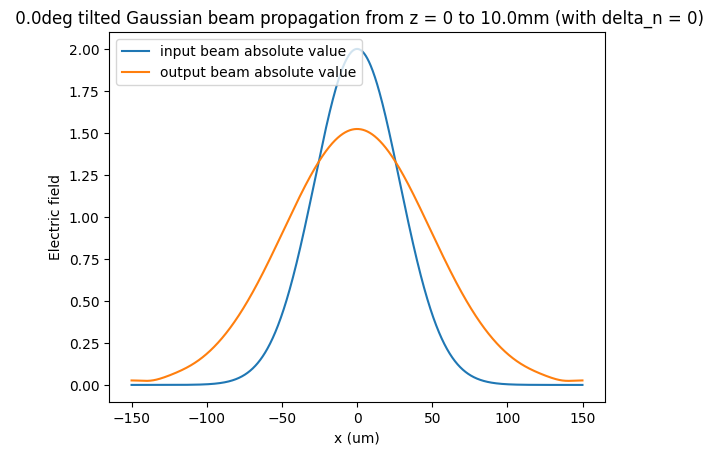

In [73]:
electrode_length = 10e3
scale_factor = 1
carrier_diffusion_length = 5

# chip parameters (lengths in MICROMETERS)
input_length = 0e3 # distance between input facet and electrode (um)
output_length = 0e3 # distance between output facet and electrode (um)
n_wg = 2.2 # effective index of waveguide
delta_n_val= 1.e-3 # (effective) index modulation in bright regions
pixel_size = electrode_length / (scale_factor*resY)

# simulation parameters
Lz = (input_length+electrode_length+output_length)*u.um # length of waveguide in microns
Lx = 300*u.um # width of simulated waveguide area in microns 
Nx = 2**11 
dz = 1.55*u.um / delta_n_val / 100
Nz = int(Lz / dz)

# create waveguide simulation object
wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um,Ncom=50)

# buttcoupling parameters
angle_deg = 0.0 #angle between waveguide facet normal and input beam in degree
w0 = 40 # beam waist (um)
#w0 = 100 # beam waist (um)

rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
E = np.abs(gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg, center_um = 0))
input_beam = torch.from_numpy(2*gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg))

delta_n = torch.from_numpy(np.zeros((Nz, Nx), dtype=np.float32))
delta_n = delta_n.to(dtype=torch.float32)  # Ensure it's float32
delta_n = delta_n * (1+0*1j)
wg.set_delta_n(delta_n)

data_V_on = wg.run_simulation(input_beam)
plt.plot(wg.x_axis.to_value(),np.abs(input_beam.numpy()),label = "input beam absolute value")
plt.plot(wg.x_axis.to_value(),np.abs(data_V_on.numpy()),label = "output beam absolute value")
delta_x_sim = wg.x_axis[np.argmax(np.abs(data_V_on.numpy()))]
angle_deg_sim = delta_x_sim/electrode_length/u.um/np.pi*180

plt.xlabel('x (um)')
plt.ylabel('Electric field')
plt.title(f' {angle_deg}deg tilted Gaussian beam propagation from z = 0 to {electrode_length/1000}mm (with delta_n = 0)')
plt.legend()
print(f"Expected beam angle is {angle_deg} deg; simulated angle is {angle_deg_sim:.3f} deg")
print(wg.difr_list)
#plt.pcolormesh(wg.z_axis/1e3, wg.x_axis, torch.abs((data_V_on).cpu()).T, cmap="inferno")

In [6]:
#wg.plot_mats()

150.0 um 14.16 30.72 3.584
0 1024


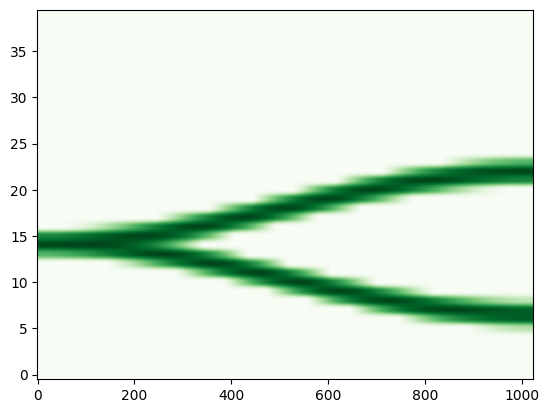

In [183]:
def generate_grin_guide_slice(cut_ind, width_one_side):
    slice_left = create_grin_beamsteerer_slice(cut_ind-width_one_side, width_one_side, slope_positive=True)
    slice_right = create_grin_beamsteerer_slice(cut_ind+width_one_side, width_one_side, slope_positive=False)
    return slice_left + slice_right - 255

#Create y-beamsplitter
xcenter = 0*u.um
xsep = 150*u.um
xwidth = 35*u.um
zstart = 0*u.um
zend = electrode_length*u.um

DMD_xcenter = (xcenter+Lx/2) * resY/Lz-1.2

DMD_xsep = xsep * resY/Lz
DMD_xwidth = xwidth * resY/Lz
DMD_ystart = zstart * resY/Lz
DMD_yend = zend * resY/Lz


print(xcenter+Lx/2,DMD_xcenter,Lx*resY/Lz,DMD_xwidth)

def sbend(idx):
    del_y = (DMD_yend - DMD_ystart)/2
    del_x = DMD_xsep/2
    return del_x/2 - del_x/2 * np.cos((idx-DMD_ystart)*np.pi/(2*del_y)*u.rad)

start = np.max([int(np.floor(DMD_ystart)), 0])
end = np.min([int(np.ceil(DMD_yend)),resY])
print(start,end)

img = generate_all_off()
for idx in np.arange(start, end):
    slice1 = generate_grin_guide_slice((DMD_xcenter + sbend(idx)).to_value(), DMD_xwidth.to_value()/4)
    slice2 = generate_grin_guide_slice((DMD_xcenter - sbend(idx)).to_value(), DMD_xwidth.to_value()/4)
    img[:, idx] = 255 - 255* (255-np.maximum(slice1, slice2).astype(float))**2/255**2
img = img.astype(np.uint8)


#img = generate_grin_y_splitter(np.arange(100,201), 100, 20)
#plot_DMD_img(img)
plt.imshow(img[0:40,:], aspect="auto", origin="lower", cmap="Greens", vmin=0)

(30, 1024) (2097, 645) (69.9, 0.6298828125)


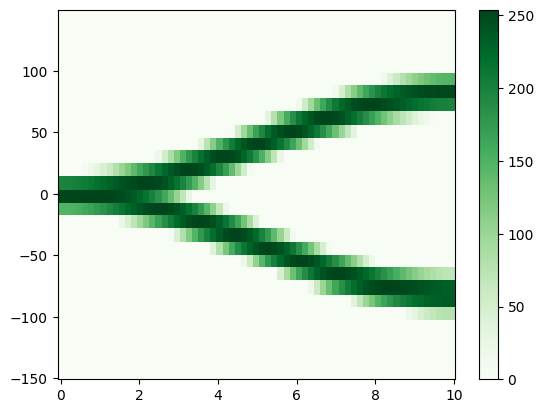

In [184]:

# Define source 2D array
resY_eff = Lx*resY/Lz
source = img[0:int(resY_eff),:].astype(np.float32)

# Define target dimensions
target_shape = (int(Nx*resY_eff/int(resY_eff)), Nz)

# Compute zoom factors
zoom_factors = (target_shape[0] / source.shape[0], target_shape[1] / source.shape[1])
print(source.shape,target_shape, zoom_factors)

# Rescale array
target = zoom(source, zoom_factors, order=0)  # order=1 for bilinear interpolation
target = target[0:Nx,:]
plt.pcolormesh(wg.z_axis[::10].to_value()/1e3, wg.x_axis[::10].to_value(),target[::10, ::10], cmap="Greens", vmin=0)
plt.colorbar()


(<Figure size 1000x600 with 12 Axes>,
 array([[<Axes: title={'center': 'Original $\\Delta n_{real}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Original $\\Delta n_{imag}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>],
        [<Axes: title={'center': 'Steady-state $\\Delta n_{real}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Steady-state $\\Delta n_{imag}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>],
        [<Axes: title={'center': 'Spatial intensity'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Wavevector intensity'}, xlabel='z (mm)', ylabel='f (1/mm)'>]],
       dtype=object))

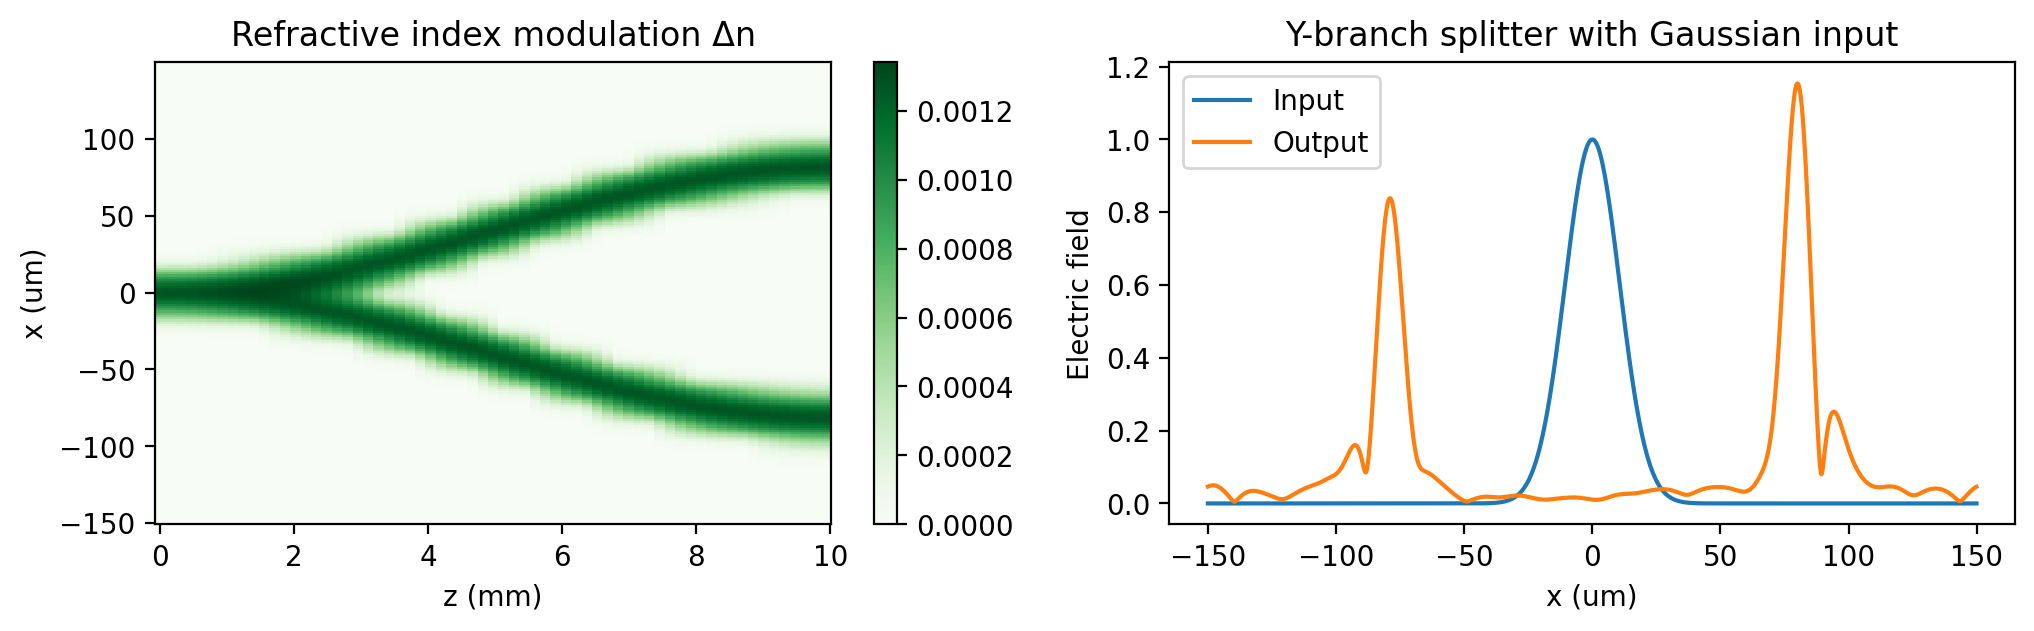

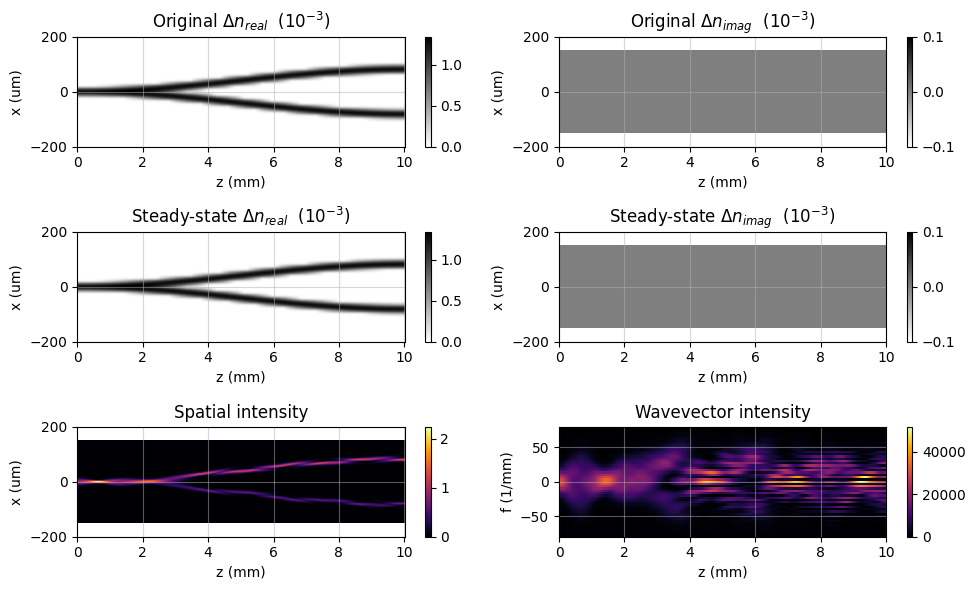

In [193]:


# create waveguide simulation object
material = Material(dx = 1*u.um, dz = 1*u.um, dnrdN = 0 * u.cm**3, a0 = 0 * u.cm**2)

wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um, material = material)

# buttcoupling parameters
angle_deg = 0.0 #angle between waveguide facet normal and input beam in degree
w0 = 15 # beam waist (um)
rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
E = np.abs(gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg, center_um = 0))
input_beam = torch.from_numpy(gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg))

delta_n = torch.from_numpy(target.T/255*0.0014)
delta_n = delta_n.to(dtype=torch.float32)  # Ensure it's float32
#wg.smoothen_spatial_map(delta_n)
delta_n_diffused = wg.smoothen_spatial_map(delta_n)
wg.set_delta_n(delta_n_diffused)
data_V_on = wg.run_simulation_slow(input_beam)

fig, axs = plt.subplots(1, 2, figsize = [12,3], dpi = 200)

plt.sca(axs[0])
plt.pcolormesh(wg.z_axis[::10].to_value()/1e3, wg.x_axis[::10].to_value(),delta_n_diffused.T[::10, ::10], cmap="Greens", vmin=0)
plt.colorbar()
plt.xlabel('z (mm)')
plt.ylabel('x (um)')
plt.title('Refractive index modulation Δn')

plt.sca(axs[1])
plt.plot(wg.x_axis.to_value(),np.abs(input_beam.numpy()),label = "Input")
plt.plot(wg.x_axis.to_value(),np.abs(data_V_on.numpy()),label = "Output")
delta_x_sim = wg.x_axis[np.argmax(np.abs(data_V_on.numpy()))]
angle_deg_sim = delta_x_sim/electrode_length/u.um/np.pi*180
plt.xlabel('x (um)')
plt.ylabel('Electric field')
plt.title(f'Y-branch splitter with Gaussian input')
plt.legend()
wg.plot_mats(renorm_flag = False)
#plt.pcolormesh(wg.z_axis/1e3, wg.x_axis, torch.abs((data_V_on).cpu()).T, cmap="inferno")

In [10]:
electrode_length = 10e3
scale_factor = 1
carrier_diffusion_length = 5

# chip parameters (lengths in MICROMETERS)
input_length = 0e3 # distance between input facet and electrode (um)
output_length = 0e3 # distance between output facet and electrode (um)
n_wg = 2.2 # effective index of waveguide
delta_n_val= 1.e-3 # (effective) index modulation in bright regions
pixel_size = electrode_length / (scale_factor*resY)

# simulation parameters
Lz = (input_length+electrode_length+output_length)*u.um # length of waveguide in microns
Lx = 300*u.um # width of simulated waveguide area in microns 
Nx = 2**11 
dz = 1.55*u.um / delta_n_val / 100
Nz = int(Lz / dz)

# create waveguide simulation object
wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um)

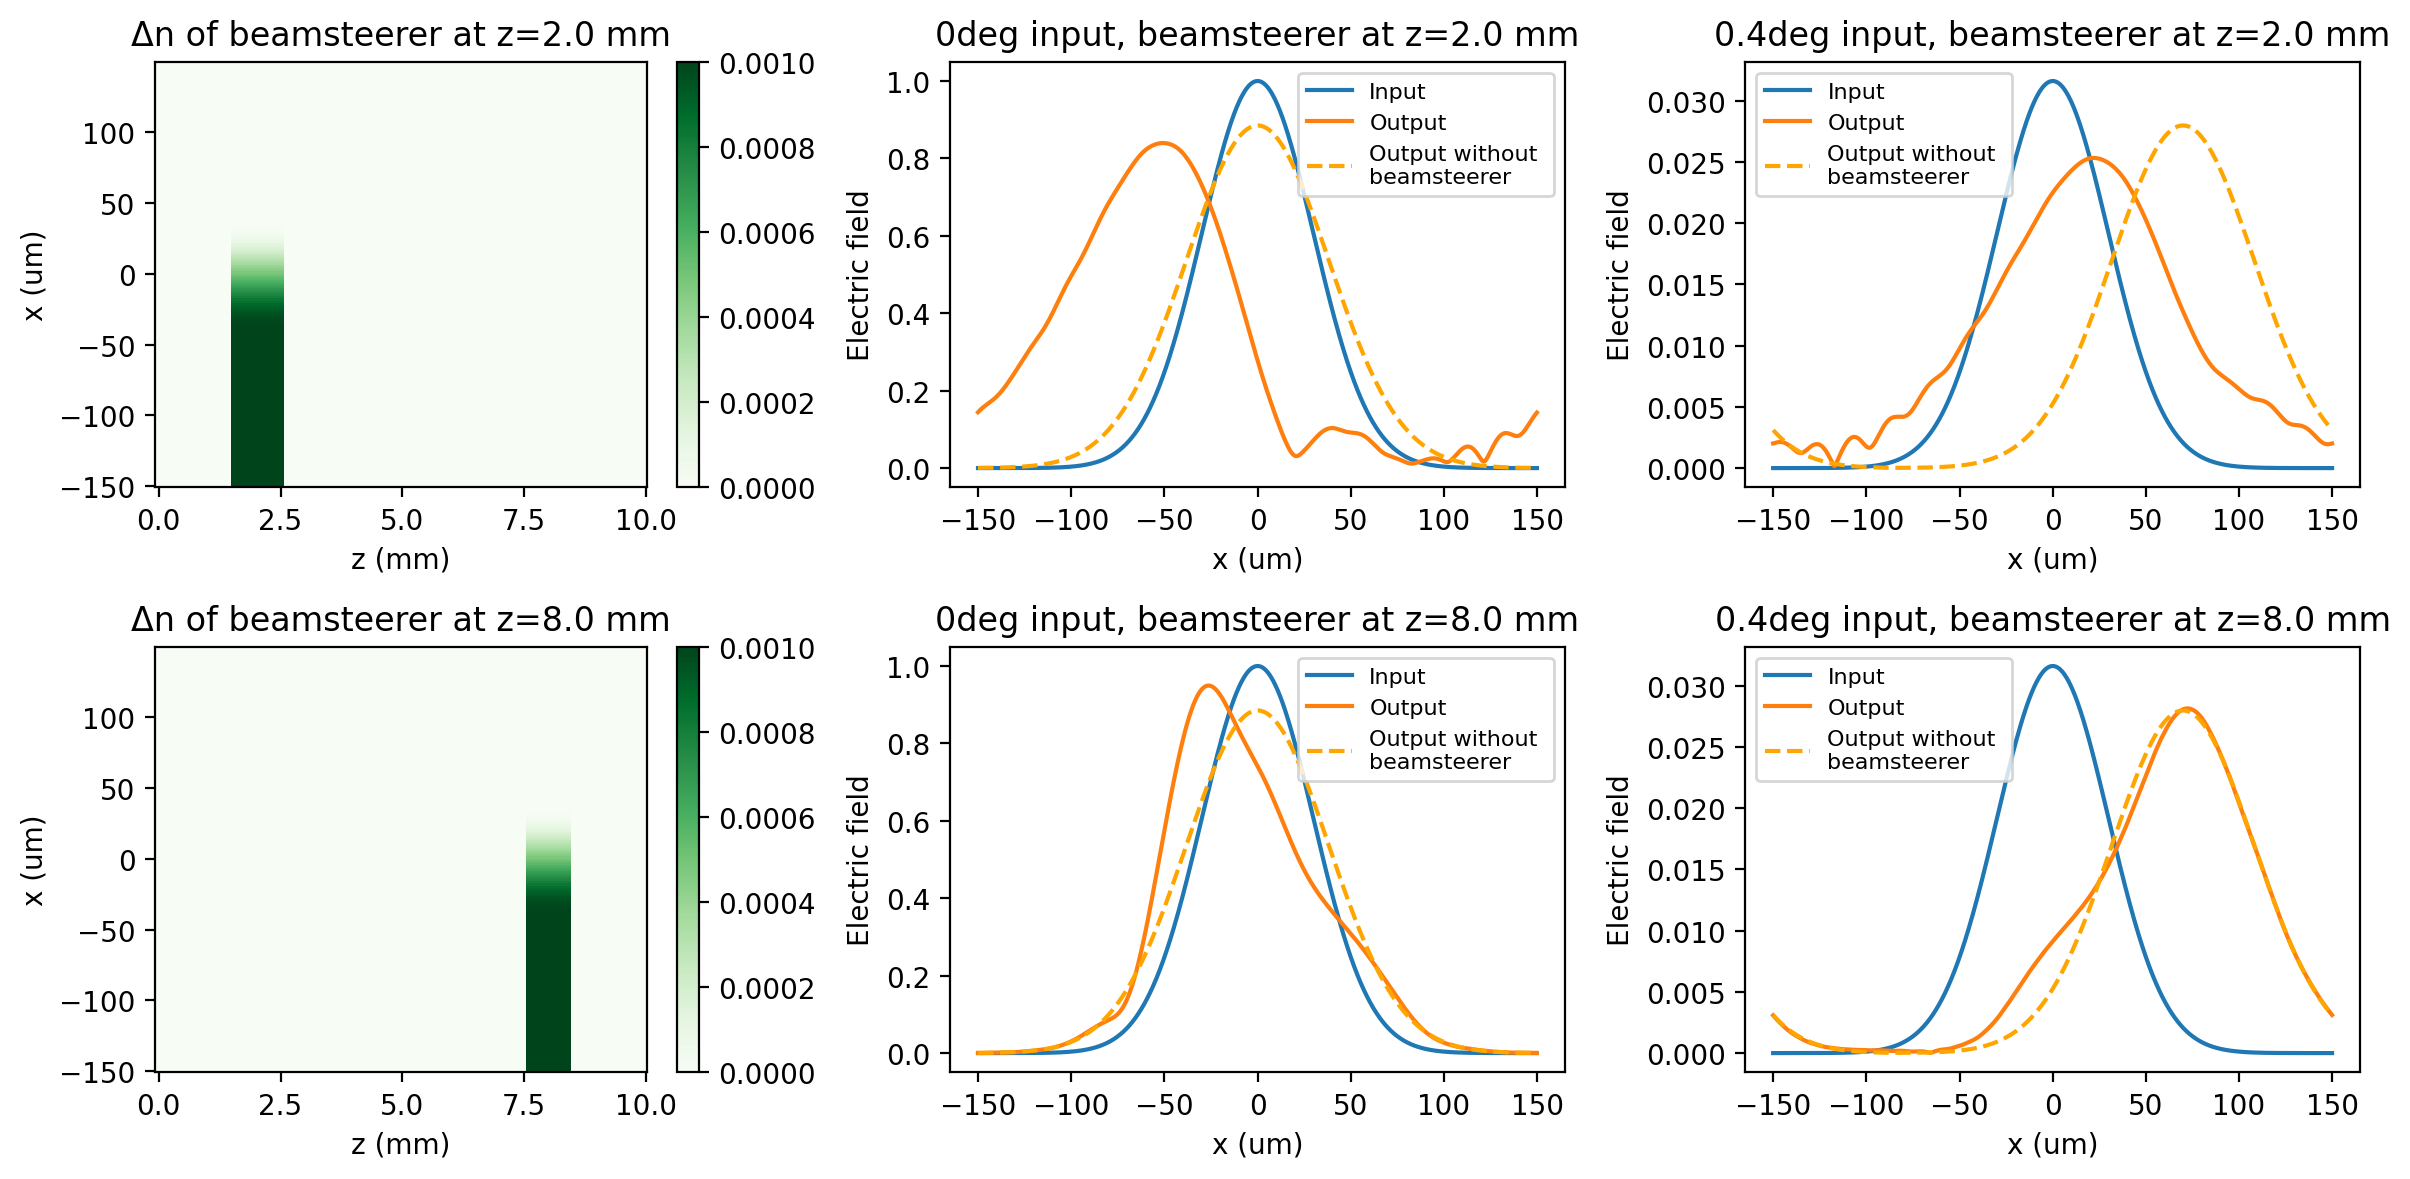

In [11]:
delta_n_off = torch.from_numpy(np.zeros((Nz, Nx), dtype=np.float32))

xwidth = 50*u.um
zwidth = 1e3*u.um
fig, axs = plt.subplots(2, 3, figsize = [12,6], dpi = 200)
i=0
#
for zposition in [2*u.mm, 8*u.mm]:
    DMD_xcenter = Lx/2 * resY/Lz-1.2
    DMD_xwidth = xwidth * resY/Lz
    DMD_zposition = zposition * resY/Lz
    DMD_zwidth = zwidth * resY/Lz
    z_range = np.arange(int(DMD_zposition-DMD_zwidth/2),int(DMD_zposition+DMD_zwidth/2))
    img = generate_grin_beamsteerer(z_range, DMD_xcenter, DMD_xwidth/2, slope_positive=False)
    
    resY_eff = Lx*resY/Lz
    source = img[0:int(resY_eff),:].astype(np.float32)
    target_shape = (int(Nx*resY_eff/int(resY_eff)), Nz)
    zoom_factors = (target_shape[0] / source.shape[0], target_shape[1] / source.shape[1])
    target = zoom(source, zoom_factors, order=0)
    target = target[0:Nx,:]
    
    delta_n = torch.from_numpy(target.T/255*0.001)
    delta_n = delta_n.to(dtype=torch.float32)  # Ensure it's float32
    delta_n_diffused = wg.smoothen_spatial_map(delta_n)
    wg.set_delta_n(delta_n_diffused)
    plt.sca(axs.flatten()[i])
    plt.pcolormesh(wg.z_axis[::10].to_value()/1e3, wg.x_axis[::10].to_value(),delta_n_diffused.T[::10, ::10], cmap="Greens", vmin=0)
    plt.colorbar()
    plt.xlabel('z (mm)')
    plt.ylabel('x (um)')
    plt.title(f'Δn of beamsteerer at z={zposition}')
    i += 1
    for angle_deg in [0, 0.4]:  #angle between waveguide facet normal and input beam in degree
        # buttcoupling parameters
        w0 = 30 # beam waist (um)
        rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
        E = np.abs(gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg, center_um = 0))
        z0 = 4*u.mm
        input_beam = torch.from_numpy(gaussian_beam_from_q_parameter(wg, z0+1j*rayleigh_range, angle_deg))
        
        data_V_on = wg.run_simulation(input_beam, delta_n = delta_n_diffused).clone()
        data_V_off = wg.run_simulation(input_beam,delta_n = delta_n_off).clone()
        
        plt.sca(axs.flatten()[i])
        plt.plot(wg.x_axis.to_value(),np.abs(input_beam.numpy()),label = "Input")
        plt.plot(wg.x_axis.to_value(),np.abs(data_V_on.numpy()),label = "Output")
        
        plt.plot(wg.x_axis.to_value(),np.abs(data_V_off.numpy()), "--", color = "orange", label = f"Output without \nbeamsteerer")
        delta_x_sim = wg.x_axis[np.argmax(np.abs(data_V_on.numpy()))]
        angle_deg_sim = delta_x_sim/electrode_length/u.um/np.pi*180
        plt.xlabel('x (um)')
        plt.ylabel('Electric field')
        plt.title(f"{angle_deg}deg input, beamsteerer at z={zposition}")
        plt.legend(fontsize=8)
        plt.tight_layout()
        i += 1

Half width of delta_n pattern is 76.77923342053572 um


(<Figure size 1000x600 with 12 Axes>,
 array([[<Axes: title={'center': 'Original $\\Delta n_{real}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Original $\\Delta n_{imag}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>],
        [<Axes: title={'center': 'Steady-state $\\Delta n_{real}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Steady-state $\\Delta n_{imag}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>],
        [<Axes: title={'center': 'Spatial intensity'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Wavevector intensity'}, xlabel='z (mm)', ylabel='f (1/mm)'>]],
       dtype=object))

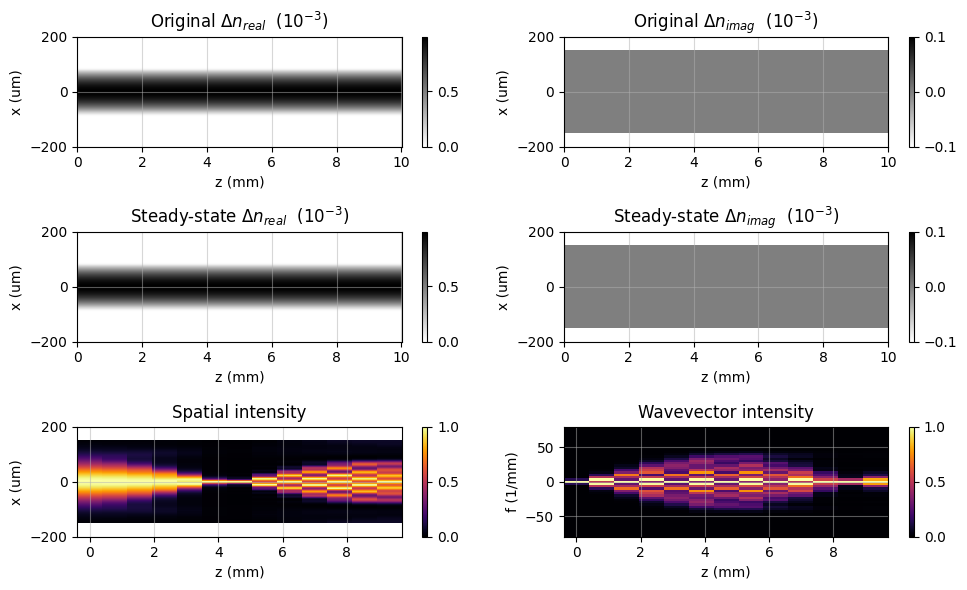

In [12]:
f = 4*u.mm  # focal length of lens
delta_n_max = 1e-3

"""
From the Eikonal ray equation, we know a quadratic delta_n(x) is needed to form a lens.
I use: delta_n(x) = delta_n_max * (1 - (x/xwidth)**2)
Using the ray equation, the xwidth needed to make a lens with focal length f is below.
(The same result can be obtained from Gaussian beam and ABCD matrix)
"""
xwidth = f.to(u.um) * sqrt(2*delta_n_max/n_wg) * 2/np.pi  # width of pattern needed for focal length f
print(f"Half width of delta_n pattern is {xwidth}")
DMD_xcenter = Lx/2 * resY/Lz-1.2
DMD_xwidth = xwidth * resY/Lz
DMD_zposition = zposition * resY/Lz
DMD_zwidth = zwidth * resY/Lz
z_range = np.arange(0, resY)
img = generate_grin_y_splitter(z_range, DMD_xcenter, DMD_xwidth/2)
img = 255 - 255 * (255-img.astype(float))**2/255**2
img = img.astype(np.uint8)

resY_eff = Lx*resY/Lz
source = img[0:int(resY_eff),:].astype(np.float32)
target_shape = (int(Nx*resY_eff/int(resY_eff)), Nz)
zoom_factors = (target_shape[0] / source.shape[0], target_shape[1] / source.shape[1])
target = zoom(source, zoom_factors, order=0)
target = target[0:Nx,:]

delta_n = torch.from_numpy(target.T/255*0.001)
delta_n = delta_n.to(dtype=torch.float32)  # Ensure it's float32
delta_n_diffused = wg.smoothen_spatial_map(delta_n)

wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um,Ncom=50)
w0 = 100 # beam waist (um)
rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
#E = np.abs(gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg, center_um = 0))
z0 = 0*u.mm
input_beam = torch.from_numpy(gaussian_beam_from_q_parameter(wg, z0+1j*rayleigh_range, 0))

data_V_on = wg.run_simulation_slow(input_beam, delta_n = delta_n_diffused).clone()
wg.plot_mats()

## Testing simple model of saturable gain

(<Figure size 1000x600 with 12 Axes>,
 array([[<Axes: title={'center': 'Original $\\Delta n_{real}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Original $\\Delta n_{imag}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>],
        [<Axes: title={'center': 'Steady-state $\\Delta n_{real}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Steady-state $\\Delta n_{imag}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>],
        [<Axes: title={'center': 'Spatial intensity'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Wavevector intensity'}, xlabel='z (mm)', ylabel='f (1/mm)'>]],
       dtype=object))

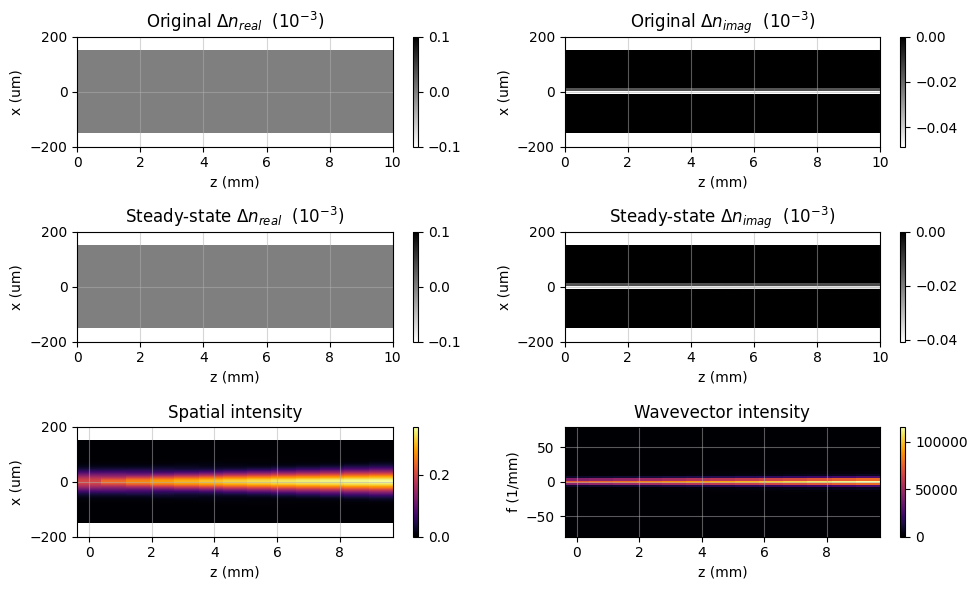

In [67]:
I_sat = 1 # Saturation intensity, defined as E^2 for simplicity
I_in = 0.2 # Input light max intensity

delta_n_max = 1e-3
n_i_min = -5e-5 # minimum n_imag of modulation pattern
xwidth = u.um * 10 # half-width-at-zero of delta_n pattern

w0 = 50 # beam waist (um)

DMD_xcenter = Lx/2 * resY/Lz-1.2
DMD_xwidth = xwidth * resY/Lz
DMD_zposition = zposition * resY/Lz
DMD_zwidth = zwidth * resY/Lz
z_range = np.arange(0, resY)
img = generate_grin_y_splitter(z_range, DMD_xcenter, DMD_xwidth/2)
img = 255 - 255 * (255-img.astype(float))**2/255**2
img = img.astype(np.uint8)

resY_eff = Lx*resY/Lz
source = img[0:int(resY_eff),:].astype(np.float32)
target_shape = (int(Nx*resY_eff/int(resY_eff)), Nz)
zoom_factors = (target_shape[0] / source.shape[0], target_shape[1] / source.shape[1])
target = zoom(source, zoom_factors, order=0)
target = target[0:Nx,:]

delta_n = torch.from_numpy(target.T/255*n_i_min*1j)
delta_n = delta_n.to(dtype=torch.complex64)  
delta_n_diffused = wg.smoothen_spatial_map(delta_n)

wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um,Ncom=50, I_sat = I_sat)


rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
z0 = 0*u.mm
input_beam = np.sqrt(I_in) * torch.from_numpy(gaussian_beam_from_q_parameter(wg, z0+1j*rayleigh_range, 0,center_um=0*u.um))

data_V_on = wg.run_simulation_slow(input_beam, delta_n = delta_n).clone()
wg.plot_mats(renorm_flag=False)

fig, axs2 = plt.subplots(1, 1, figsize=(6, 4))  # Create a new axis for the plot below
plt.sca(axs2)
plt.plot(wg.x_axis.to_value(),np.abs(input_beam.numpy()),label = "Input")
plt.plot(wg.x_axis.to_value(),np.abs(data_V_on.numpy()),label = "Output")
plt.xlabel('x (um)')
plt.ylabel('Electric field')
plt.title("Input & output Electric fields")
plt.legend(fontsize=8)

P_0 is the input total power when its peak intensity = 1


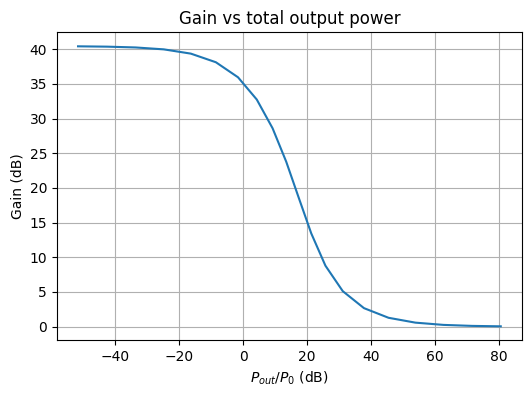

In [58]:
I_sat = 1 # Saturation intensity, defined as E^2 for simplicity

delta_n_max = 1e-3
n_i_min = -5e-5 # minimum n_imag of delta_n pattern
xwidth = u.um * 1e10 # half-width-at-zero of delta_n pattern

w0 = 50 # beam waist (um)

DMD_xcenter = Lx/2 * resY/Lz-1.2
DMD_xwidth = xwidth * resY/Lz
DMD_zposition = zposition * resY/Lz
DMD_zwidth = zwidth * resY/Lz
z_range = np.arange(0, resY)
img = generate_grin_y_splitter(z_range, DMD_xcenter, DMD_xwidth/2)
img = 255 - 255 * (255-img.astype(float))**2/255**2
img = img.astype(np.uint8)

resY_eff = Lx*resY/Lz
source = img[0:int(resY_eff),:].astype(np.float32)
target_shape = (int(Nx*resY_eff/int(resY_eff)), Nz)
zoom_factors = (target_shape[0] / source.shape[0], target_shape[1] / source.shape[1])
target = zoom(source, zoom_factors, order=0)
target = target[0:Nx,:]

delta_n = torch.from_numpy(target.T/255*n_i_min*1j)
delta_n = delta_n.to(dtype=torch.complex64)
#delta_n_diffused = wg.smoothen_spatial_map(delta_n)
#print(torch.is_complex(delta_n_diffused))

wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um,Ncom=50, I_sat = I_sat)

rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
z0 = 0*u.mm

I_in_vals = 10**np.linspace(-4, 3.5, num=20) # Input intensity
#I_in_vals = np.linspace(0.3, 0.3, num=1)

input_beam_1 = torch.from_numpy(gaussian_beam_from_q_parameter(wg, z0+1j*rayleigh_range, 0,center_um=0*u.um))
P_in_1 = wg.dx.value * torch.sum(torch.abs(input_beam_1)**2).numpy()
P_in_vals = I_in_vals * P_in_1  # Input power
P_out_vals = np.zeros(len(I_in_vals)) # Output power

for (i, I_in) in enumerate(I_in_vals):
    input_beam = np.sqrt(I_in) * input_beam_1
    data_V_on = wg.run_simulation_slow(input_beam, delta_n = delta_n.clone()).clone()
    #P_out_vals[i] = I_in * torch.sum(torch.abs(data_V_on)**2) / torch.sum(torch.abs(input_beam)**2)
    P_out_vals[i] = wg.dx.value * torch.sum(torch.abs(data_V_on)**2)

gain = P_out_vals/P_in_vals
gain_db = 10*np.log(gain)
P_out_db = 10*np.log(P_out_vals / P_in_1)
P_in_db = 10*np.log(P_in_vals / P_in_1)

#print("gain", gain)
#print("in" , P_in_vals)
#print("out", P_out_vals)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))  # Create a new axis for the plot below
plt.sca(ax)
plt.plot(P_out_db,gain_db)
plt.xlabel(r'$P_{out} / P_0$ (dB)')
plt.ylabel('Gain (dB)')
plt.title("Gain vs total output power")
plt.grid(True)

print(r"P_0 is the input total power when its peak intensity = 1")


N_tr = 
tau_s = 
a0 = 

Parameters:
nr: refractive index real part
ni: refractive index imaginary part
E: electric field
current: injected current
N: carrier concentration


Initial condition of iteration: nr(x,z-dz/2), ni(x,z-dz/2), E(x,z), injected_current(x, z+dz/2)
Result we want: n(x,z+dz/2), E(x,z+dz)
Steps:
1. nr(x,z-dz/2), ni(x,z-dz/2), E(x,z) => approximate values of E(x,z+dz/2)
2. E(x,z+dz/2), current(x, z+dz/2) => N(x,z+dz/2), ni(x,z+dz/2), where N is carrier density
3. N(x,z+dz/2) => nr(x,z+dz/2)
4. nr(x,z+dz/2), ni(x,z+dz/2) => E(x,z+dz)



## Define Material class

(A copy of the code when it was under development is below. The working code is in simulation.py.)

import torch
import numpy as np
import astropy.units as u
import astropy.constants as const

from scipy.ndimage import zoom

from dataclasses import dataclass, fields

import pprint

@dataclass
class Material:
    '''
    Carrier rate equation model: dN/dt = injection_rate + spontaneous_decay_rate + stimulated_decay_rate
    Reference: 
        [1] Semiconductors on NSM, https://www.ioffe.ru/SVA/NSM/Semicond/GaInAsP/index.html
        [2] Material gain of bulk 1.55 mm InGaAsP/InP semiconductor optical amplifiers approximated by a polynomial model,
            https://doi.org/10.1063/1.371909
        [3] Diode Lasers and Photonic Integrated Circuits, https://onlinelibrary.wiley.com/doi/book/10.1002/9781118148167
        [4] Semiconductor Optical Amplifiers Modeling, Signal Regeneration and Conversion, 
            https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/272998/1/20180627_Thesis_Marculescu_Book_noCV.pdf
    injection_rate = current/(e*V)
        current: injected current
        e: electrical charge
        V = core thickness * dx * dz: volume of active region
            dx, dz: simulation grid sizes in the x and z directions, respectively
    spontaneous_decay_rate = (N-N0)*(A + B*(N-N0) + C*(N-N0)**2)
        N0: intrinsic carrier density, or steady state N when current, P = 0 (4.4e9 cm^(-3) (for y=0.47); 6.7e11 cm^(-3) (for y=1.0))
            I included N0 to account for thermal generation. Although I'm not sure if the form is the most appropriate.
            N0 is really small compared to any N when current is injected (~1e18 cm^(-3)) so probably don't really need to be considered
        A: recombination at defects and surfaces
        B: Radiative recombination coefficient = bimolecular recombination coefficient (e.g. 1.1e-10 cm^3/s [1]) 
        C: Auger recombination coefficient (e.g. 2.9e-30 cm^6/s [1]) 
    stimulated_decay_rate = g_m * P * confinement_factor/ (hbar * omega * area)
        g_m = a0*(N-N_tr): material power gain coefficient
            There are other possible models. But the ones I found don't seem to be directly applicable
                For quantum well (QW) lasers, g_m = a0*ln(N-N_tr) is a good model.
                For semiconductor optical amplifiers (SOAs), g_m = a0*(N-N_tr) + abar*a0*exp(-N/N0)
            a0: differential gain (e.g. 3.133e-20 m^2 [2])
            N_tr: transparency value of carrier density (e.g. 6.5e23 m^(-3) [2])
        P: optical power in area
        confinement_factor: confinement factor of fundamental mode in 2D waveguide.
            Depends on core thickness, wavelength, n_core, and n_cladding
        area = core thickness * dx: cross-section area of the active region

    Custom definition of n_i (imaginary part of the effective index):
        Power gain model: dP/dz = (g_m * confinement_factor - internal_loss) * P (Equation 2.13 of [4])
        |E|^2 is proportional to P, therefore d|E|/dz = 1/2 * (g_m * confinement_factor - internal_loss) * |E|
        I define n_i such that when sending a uniform input into the 2D waveguide with a uniform n distribution, we have
        |E(z)| = |E(0)| * exp(-n_i * omega / c * z).
        => d|E|/dz = -n_i * omega / c * |E|
        Comapring the two d|E|/dz equations, we get
        n_i = -1/2 * c / omega * (g_m * confinement_factor - internal_loss)
    '''

    # dataclass doesn't actually enforce the datatypes defined below
    dx: u.Quantity
    dz: u.Quantity
    thickness: u.Quantity = 1*u.um
    N0: u.Quantity = 1e11/u.cm**3 # Arbitraty value taken within range of values from [1]. Should be close to actual value. Doesn't matter since it's small.
    A: u.Quantity = 0/u.s # Probably depends on device
    B: u.Quantity = 1.1e-10 * u.cm**3/u.s # From [1]. Should be close to actual according to [3]
    C: u.Quantity = 2.9e-30 * u.cm**6/u.s # From [1]. Depends strongly on x and y of material, need to adjust
    confinement_factor: float = 1 # Need to adjust based on device
    omega: u.Quantity = 2*np.pi * const.c / (1550 * u.nm)
    a0: u.Quantity = 3.133e-16 * u.cm**2 # From [2]
    N_tr: u.Quantity = 6.5e17 / u.cm**3 # From [2]
    dnrdN: u.Quantity = -1e-20 * u.cm**3
    internal_loss: u.Quantity = 0 / u.cm
    
    

    def __post_init__(self):
        # Custom initialization logic
        self.hbar = const.hbar
        self.e = const.e
        self.c = const.c
        self.current, self.P, self.N = sp.symbols('current P N')
        self.dNdt = self.get_symbolic_dNdt()
        self.steady_state_N_function = sp.lambdify((self.current, self.P), sp.solve(self.dNdt, self.N), 'numpy')
        self.N = np.array([])
        self.delta_n = np.array([]) # Definition: delta_n = n - n_real(current = 0, P = 0)

    def __str__(self):
        return pprint.pformat(m.__dict__)
    
    def get_symbolic_dNdt(self):
        # Return a symbolic expression of dN/dt as a function of current, P, N (all need to be their values in SI unit) using sympy (sp)
        values = {}
        attr_names = ['e', 'dx', 'dz', 'thickness', 'N0', 'A', 'B', 'C', 'confinement_factor', 'hbar', 'omega', 'a0', 'N_tr']
        for attr in attr_names:
            value = getattr(self, attr)
            value = self.to_SI(value)
            values[attr] = value
        e, dx, dz, thickness, N0, A, B, C, confinement_factor, hbar, omega, a0, N_tr = [values[attr] for attr in attr_names]
        current, P, N = self.current, self.P, self.N

        area = dx * thickness
        V = area * dz
        g_m = a0*(N-N_tr)
        
        injection_rate = current/(e * V)
        spontaneous_decay_rate = (N-N0)*(A + B*(N-N0) + C*(N-N0)**2)
        stimulated_decay_rate = g_m * P * confinement_factor/ (hbar * omega * area)
        return injection_rate - spontaneous_decay_rate - stimulated_decay_rate

    def get_steady_state_N(self, current, P):
        # Parameters: injected current and optical power P (in SI unit or Astropy Quantity)
        # Returns: value of steady N (in u.cm**(-3))
        current = np.array(self.to_SI(current)).astype(np.complex64)
        P = np.array(self.to_SI(P)).astype(np.complex64)
        result = self.steady_state_N_function(current, P)
        return np.max(np.real(result), axis=0)/(100*u.cm)**3
        #return (result, np.max(np.real(result), axis=0))

    def get_delta_n_r(self, N):
        # Parameter: steady state carrier density N (np array of values in SI unit or Astropy Quantity)
        # Returns: real part of the effective index difference
        return self.to_SI(N) * self.to_SI(self.dnrdN)

    def get_n_i(self, N):
        # Parameter: steady state carrier density N (np array of values in SI unit or Astropy Quantity)
        # Returns: imaginary part of the effective n
        N = self.to_astropy_qty(N, 1/u.m**3)
        g_m = (N - self.N_tr) * self.a0
        return -1/2 * self.c / self.omega * (g_m * self.confinement_factor - self.internal_loss)

    def update(self, current, P, update_delta_n_r = True):
        self.N = self.get_steady_state_N(current, P)
        if update_delta_n_r:
            delta_n_r = self.get_delta_n_r(self.N)
        else:
            delta_n_r = 0
        n_i = self.get_n_i(self.N)
        self.delta_n = np.array(delta_n_r + n_i * 1j).astype(np.complex64)
        return self.delta_n
    
    def to_SI(self, value):
        # If valueis an Astropy Quantity, return its value in SI unit
        # Else return itself 
        if isinstance(value, u.Quantity):
            return value.si.value
        else:
            return value

    def to_astropy_qty(self, value, unit):
        # unit must be an Astropy Quantity
        # If value is an Astropy Quantity, return itself
        # Else return value * unit
        if isinstance(value, u.Quantity):
            return value
        else:
            return value * unit

        

m = Material(dx=wg.dx, dz=wg.dz)
print("Material properties:")
#print(m)
a = m.update(np.array([[1,10],[100,200]])/Nx/Nz,[[0,0],[0,0]])
print(a)
print(m.get_steady_state_N(0,0))

## Plotting simulated steady-state refractive index vs current and optical power


material properties
{'A': <Quantity 0. 1 / s>,
 'B': <Quantity 1.1e-10 cm3 / s>,
 'C': <Quantity 2.9e-30 cm6 / s>,
 'N': array([], dtype=float64),
 'N0': <Quantity 1.e+11 1 / cm3>,
 'N_tr': <Quantity 6.5e+17 1 / cm3>,
 'P': P,
 'a0': <Quantity 3.133e-16 cm2>,
 'c': <<class 'astropy.constants.codata2018.CODATA2018'> name='Speed of light in vacuum' value=299792458.0 uncertainty=0.0 unit='m / s' reference='CODATA 2018'>,
 'confinement_factor': 1,
 'current': current,
 'dNdt': -5.32416558377596e+31*P*(3.133e-20*N - 20364.5) + 2.74266056152375e+36*current - (N - 1.0e+17)*(1.1e-16*N + 2.9e-8*(1.0e-17*N - 1)**2 - 11.0),
 'delta_n': array([], dtype=float64),
 'dnrdN': <Quantity -1.e-20 cm3>,
 'dx': <Quantity 0.14655594 um>,
 'dz': <Quantity 15.52795031 um>,
 'e': <<class 'astropy.constants.codata2018.EMCODATA2018'> name='Electron charge' value=1.602176634e-19 uncertainty=0.0 unit='C' reference='CODATA 2018'>,
 'hbar': <<class 'astropy.constants.codata2018.CODATA2018'> name='Reduced Planck cons

Text(0.5, 1.0, '$n_{eff,imag}$')

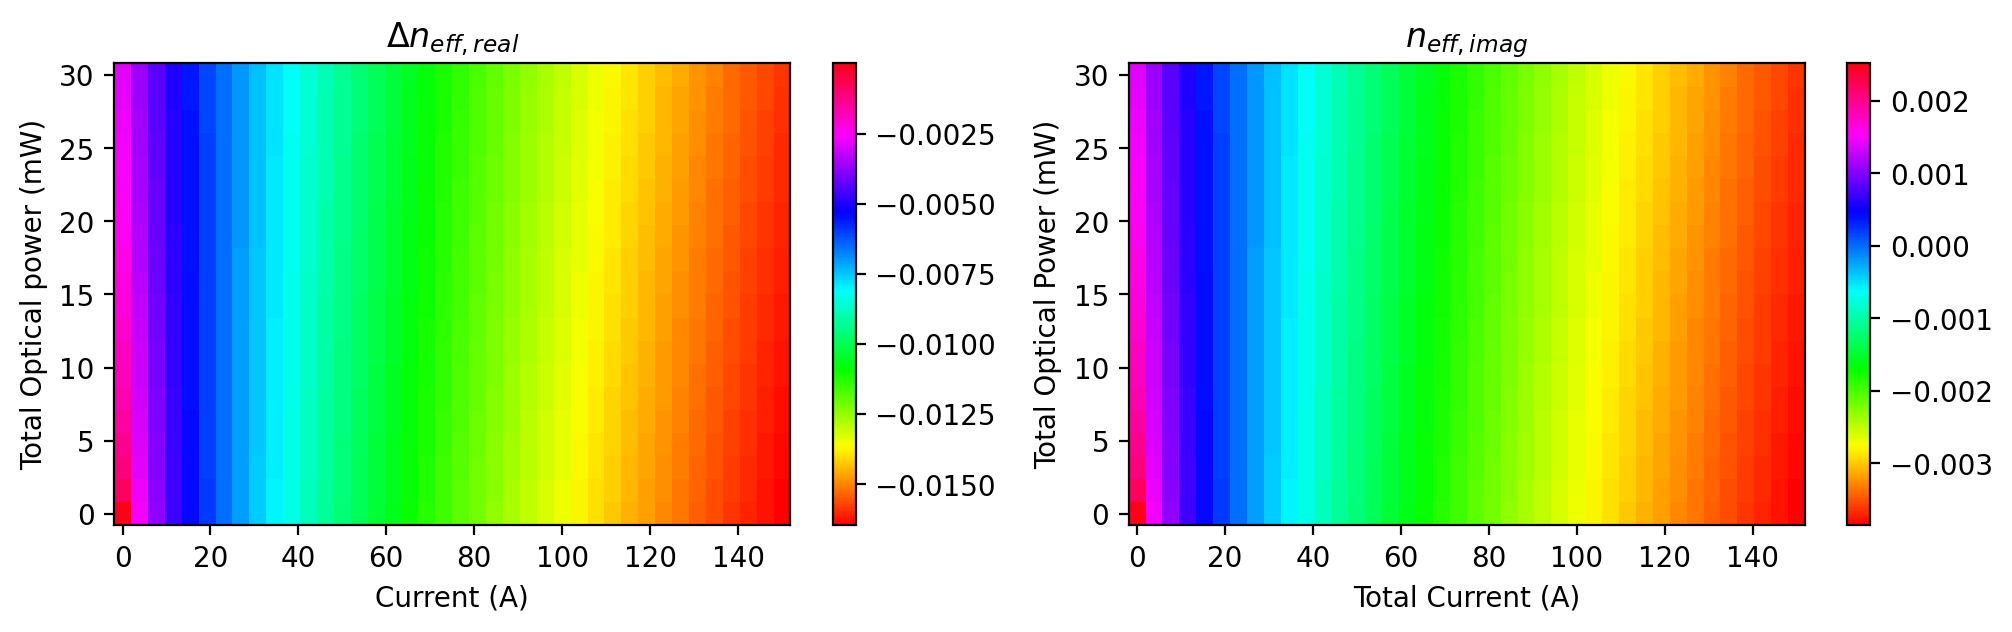

In [59]:
from tdwg.lib.simulation import *

thickness = 1*u.um
m = Material(dx=wg.dx, dz=wg.dz, thickness=thickness)
print("material properties")
#print(m)

max_P = 10e6*u.mW/u.cm**2 * Lx * thickness
max_current = 5 * u.kA/u.cm**2 * Lx * Lz
current_values = np.linspace(0,1,40) * max_current
P_values = np.linspace(0,1,20) * max_P

X, Y = np.meshgrid(current_values/(Nx*Nz),P_values/Nx)
n = m.update(X,Y)
fig, axs = plt.subplots(1, 2, figsize = [12,3], dpi = 200)

plt.sca(axs[0])
plt.pcolormesh(current_values.to(u.A).value, P_values.to(u.mW).value, np.real(n), cmap="hsv", shading="auto")
plt.colorbar()
plt.ylabel("Total Optical power (mW)")
plt.xlabel("Current (A)")
plt.title(r"$\Delta n_{eff,real}$")

plt.sca(axs[1])
plt.pcolormesh(current_values.to(u.A).value, P_values.to(u.mW).value, np.imag(n), cmap="hsv", shading="auto")
plt.colorbar()
plt.ylabel("Total Optical Power (mW)")
plt.xlabel("Total Current (A)")
plt.title(r"$n_{eff,imag}$")


The plots above are the steady-state effective index change at z=0 when a uniform current density is injected across Lx * Lz and a plane wave is incident on the z=0 (entrance) of the waveguide. The label Total Current is the total current across Lx * Lz, and the label Total Optical power is the total power across Lx * thickness.

(Lx, Ly, thickness: width, length, and thickness of 2D waveguide)

The $\Delta n_{eff, real}$ and $n_{eff,imag}$ plots look exactly the same (but with with different colorbar values) because they are both modeled as linear functions of the carrier density.

($n_{eff,imag}$ is defined such that there is optical gain when it's negative)

## Definition of input field $a$

I want to define the input field $a(x,z)$ such that the optical power across each $dx$ is

$dP = |a(x,z)|^2 dx$. 

In the mean time, we need $a$ to have the correct phase for the simulation.
Therefore, I define:

$a(x,z)= \frac{E}{|E|} \sqrt{\frac{1}{2} \epsilon_0 c \int_{-\infty}^{\infty} n_{eff,real}(x,z) |E(x,y,z)|^2 dy}$.

Since $max(\Delta n_{eff,real})$ is around 0.02, which is not too big, we might want to use a simpler definition:

$a(x,z)= \frac{E}{|E|} \sqrt{\frac{1}{2} \epsilon_0  n_{eff,0} c \int_{-\infty}^{\infty} |E(x,y,z)|^2 dy}$,

where $n_{eff,0}$ is the effective index without injected current or incident light.

G

## Simulation test

-5.32416558377596e+31*P*(3.133e-20*N - 20364.5) + 2.74266056152375e+36*current - (N - 1.0e+17)*(1.1e-16*N + 2.9e-8*(1.0e-17*N - 1)**2 - 11.0) N
[-2.53752974960836e-28*(1.43876337693222e+51 - 1.72558042489346e+54*P)/(-0.045539689807754*P - 0.00563254958948264*current + (-(0.000833785175223611 - P)**3 + 0.00207386334778645*(-P - 0.123684408331732*current + 0.000528677935610346)**2)**0.5 + 2.40758291958989e-5)**(1/3) - 4.37871166350896e+26*(-0.045539689807754*P - 0.00563254958948264*current + (-(0.000833785175223611 - P)**3 + 0.00207386334778645*(-P - 0.123684408331732*current + 0.000528677935610346)**2)**0.5 + 2.40758291958989e-5)**(1/3) - 1.26436780609195e+25, -2.53752974960836e-28*(-0.5 - 0.866025403784439*I)*(1.43876337693222e+51 - 1.72558042489346e+54*P)/(-0.045539689807754*P - 0.00563254958948264*current + (-(0.000833785175223611 - P)**3 + 0.00207386334778645*(-P - 0.123684408331732*current + 0.000528677935610346)**2)**0.5 + 2.40758291958989e-5)**(1/3) - 4.37871166350896e+26*(-0.5 +

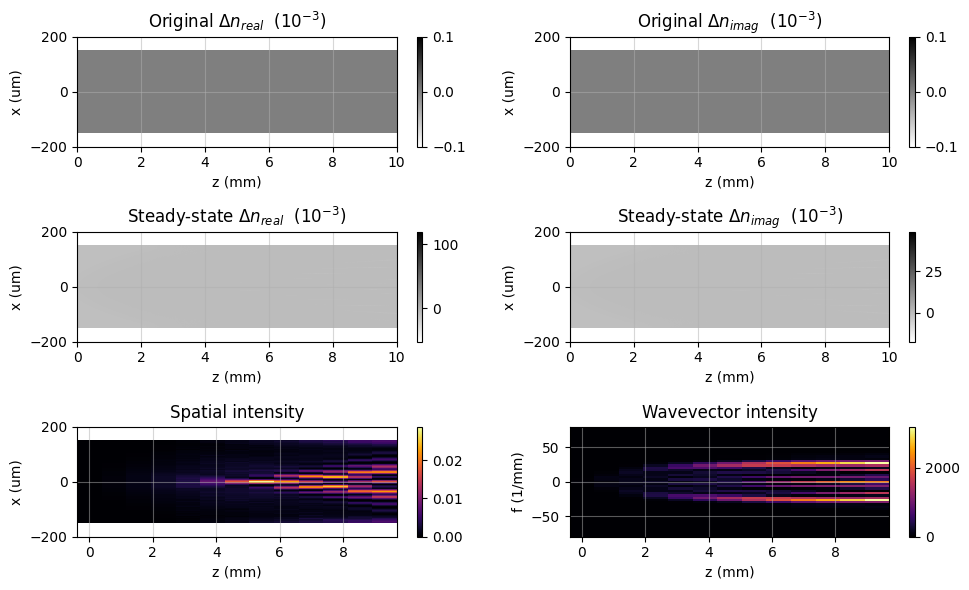

In [159]:
mod = reload(sys.modules['tdwg.lib.simulation']) # use imp.reload for Python 3  
vars().update(mod.__dict__)     # update the global namespace

electrode_length = 10e3
scale_factor = 1
carrier_diffusion_length = 5
# chip parameters (lengths in MICROMETERS)
input_length = 0e3 # distance between input facet and electrode (um)
output_length = 0e3 # distance between output facet and electrode (um)
n_wg = 2.2 # effective index of waveguide
delta_n_val= 1.e-3 # (effective) index modulation in bright regions
pixel_size = electrode_length / (scale_factor*resY)
# simulation parameters
Lz = (input_length+electrode_length+output_length)*u.um # length of waveguide in microns
Lx = 300*u.um # width of simulated waveguide area in microns 
Nx = 2**11 
dz = 1.55*u.um / delta_n_val / 100
Nz = int(Lz / dz)
current = 1*40*u.A/(Nx*Nz) * np.ones((Nz, Nx))
# create waveguide simulation object
wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um,Ncom=50,current = current)

m = wg.material
delta_n = wg.get_delta_n_active_slice([1.000,1], [2,2])
print(m.dNdt, m.N)
print(sp.solve(m.dNdt, m.N))
#print(m)


w0 = 50 # beam waist (um)
rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
z0 = 0*u.mm
input_amplitude = np.sqrt(30*u.mW / Lx) # This is high, maybe close to the max allowable light amplitude
print("input amplitude:",input_amplitude.si.value)
input_beam = (0.001+1e-8) * input_amplitude.si.value * torch.from_numpy(gaussian_beam_from_q_parameter(wg, z0+1j*rayleigh_range, 0, center_um=0*u.um))

data_V_on = wg.run_simulation_slow(input_beam).clone()
wg.plot_mats(renorm_flag=False)
print("")



## Simple performance test

In [17]:
import time

#f_numeric = sp.lambdify((m.current, m.P), m.steady_state_N_function, 'numpy')

# Start timer
print(Nx, Nz)
iterations = Nx * Nz
scaling_factor = Nz
iterations = np.round(Nx * Nz / scaling_factor).astype(int)
print(iterations)
current_values = np.random.random(iterations)
P_values = np.random.random(iterations)

t0 = time.time()

#for j in range(iterations):
    #m.get_steady_state_N(1,2)
#    pass

t1 = time.time()

#for j in range(iterations):
#    f_numeric(current_values[j],P_values[j])

t2 = time.time()

for j in range(Nz):
    a = current_values*j
    a = a*j+a

t4 = time.time()

t3 = time.time()
for j in range(Nz):
    a = m.get_steady_state_N(current_values, P_values)

t4 = time.time()

time_cost = np.array([t1-t0, t2-t1, t3-t2, t4-t3])*scaling_factor**0
print(time_cost)


2048 645
2048
[0.         0.         0.00206137 1.28106809]


## Misc

$\frac{\alpha}{1}$
Lambert W function

In [23]:
class Test:
    def __init__(self):
        self.a = 1

test = Test()
#print(m.__dict__)
#print(test.a)

In [19]:
a = np.array([1, 2])*2*u.um
print(isinstance(a, u.Quantity))


True


In [20]:
a = np.array([1,2])
b = a
#b[1] = 3
b = [2,4]
print(a,b)

[1 2] [2, 4]


In [34]:
mod = reload(sys.modules['tdwg.lib.simulation'])#use imp.reload for Python 3  
vars().update(mod.__dict__)     #update the global namespace


In [107]:
current = torch.from_numpy(np.zeros((10,20), dtype=np.float32))
current.shape != (10, 20)

False

In [180]:
def compute_with_warning():
    mod = reload(sys.modules['tdwg.lib.simulation']) # use imp.reload for Python 3  
    vars().update(mod.__dict__)     # update the global namespace
    
    electrode_length = 10e3
    scale_factor = 1
    carrier_diffusion_length = 5
    # chip parameters (lengths in MICROMETERS)
    input_length = 0e3 # distance between input facet and electrode (um)
    output_length = 0e3 # distance between output facet and electrode (um)
    n_wg = 2.2 # effective index of waveguide
    delta_n_val= 1.e-3 # (effective) index modulation in bright regions
    pixel_size = electrode_length / (scale_factor*resY)
    # simulation parameters
    Lz = (input_length+electrode_length+output_length)*u.um # length of waveguide in microns
    Lx = 300*u.um # width of simulated waveguide area in microns 
    Nx = 2**11 
    dz = 1.55*u.um / delta_n_val / 100
    Nz = int(Lz / dz)
    current = (0.2+1e-9)*40*u.A/(Nx*Nz) * np.ones((Nz, Nx))
    # create waveguide simulation object
    wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um,Ncom=50,current = current)
    
    m = wg.material
    delta_n = wg.get_delta_n_active_slice([1.000,1], [2,2])
    #print(m.dNdt, m.N)
    #print(sp.solve(m.dNdt, m.N))
    #print(m)
    
    
    w0 = 50 # beam waist (um)
    rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
    z0 = 0*u.mm
    input_amplitude = np.sqrt(30*u.mW / Lx) # This is high, maybe close to the max allowable light amplitude
    print("input amplitude:",input_amplitude.si.value)
    input_beam = (0.1+1e-8) * input_amplitude.si.value * torch.from_numpy(gaussian_beam_from_q_parameter(wg, z0+1j*rayleigh_range, 0, center_um=0*u.um))
    
    data_V_on = wg.run_simulation_slow(input_beam).clone()
    wg.plot_mats(renorm_flag=False)
    print("")
    


input amplitude: 10.0



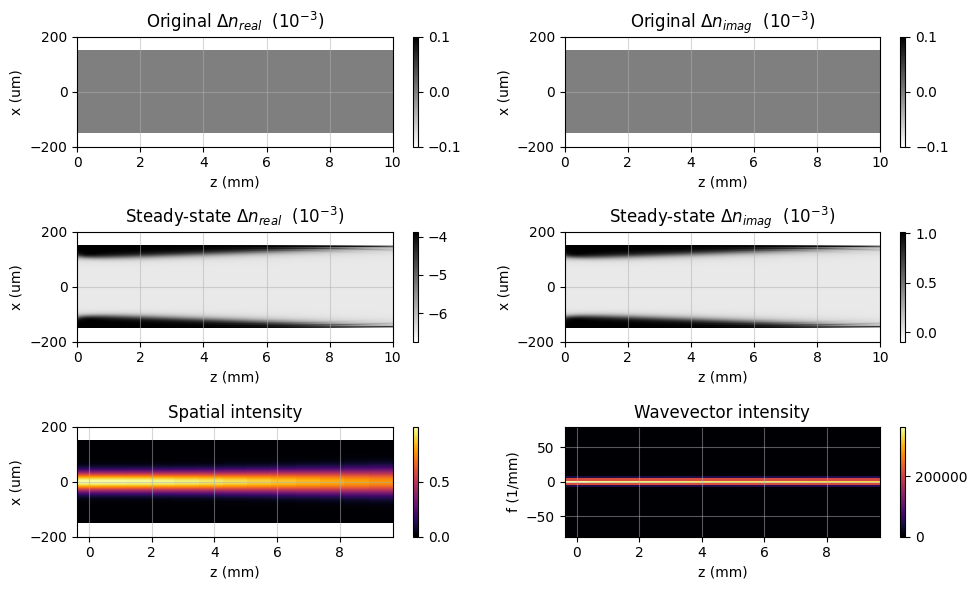

In [181]:
compute_with_warning()

input amplitude: 10.0

Warning caught: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
Warning caught: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
Warning caught: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
Warning caught: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
Warning caught: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
Warning caught: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
Warning caught: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must im

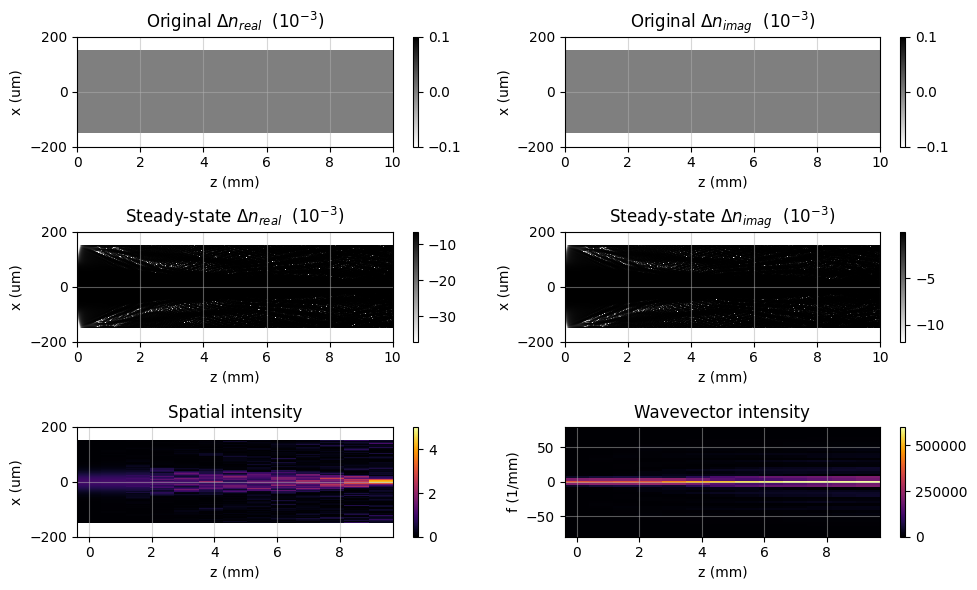

In [177]:
import warnings
import numpy as np

# Function to execute your computation


# Catch warnings as exceptions
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")  # Always catch warnings
    compute_with_warning()  # Execute your function
    
    # Check if any warnings were triggered
    if w:
        for warning in w:
            print(f"Warning caught: {warning.message}")
            # You can check the warning category if needed
            if issubclass(warning.category, RuntimeWarning):
                print("A RuntimeWarning was encountered.")

# Continue with your code
